In [52]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load dataframe 
users_df = pd.read_pickle('cleaned_data/bikes_logistic.pkl')

In [3]:
users_df.above_avg_casual.value_counts(normalize=True)

0    0.63991
1    0.36009
Name: above_avg_casual, dtype: float64

In [60]:
users_df.head(3)

,temp,hum,windspeed,season_spring,season_summer,season_winter,yr_2012,hr_1,hr_10,hr_11,...,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working,weathersit_heavy_rain_snow,weathersit_light_rain_snow,weathersit_mist,above_avg_casual
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,-1.427116,0.932170,0.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.514128,0.928318,0.0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.514128,0.928318,0.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### labels imbalances 
64% below and 36% above casual user

need do weighted sampling 

In [4]:
#Define appropriate X and y
X = users_df.drop(columns=['above_avg_casual'])
y = users_df.above_avg_casual
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [5]:
display(y_train.value_counts(normalize = True))
display(y_test.value_counts(normalize=True))
# similar distribution for both 

0    0.636643
1    0.363357
Name: above_avg_casual, dtype: float64

0    0.649712
1    0.350288
Name: above_avg_casual, dtype: float64

In [8]:
def logreg(weight):
    '''
    inputs:
    weight: class weight for logreg 
    returns:
    y_hat_test
    y_score
    fpr,tpr, thresholds 
    also auc curve 
    '''
    logreg = LogisticRegression(
        fit_intercept=True, C=1e12, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train,y_train)
    print(model_log)
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC:',  auc(fpr, tpr))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve')
    return model_log, y_hat_test, y_score, fpr, tpr, thresholds 
    

In [9]:
weights = [None, 'balanced', {1:0.36, 0:0.64}]

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC: 0.8740559408984673


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([ 0.34789403, -2.45758745, -3.4905831 , ..., -3.2896469 ,
        -2.36635946, -2.03288323]),
 array([0.        , 0.        , 0.        , ..., 0.93907191, 0.93907191,
        1.        ]),
 array([0.00000000e+00, 6.57030223e-04, 5.78186597e-02, ...,
        9.99342970e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  6.55789329,   5.55789329,   3.82205929, ...,  -4.74735501,
         -4.75236369, -11.794512  ]))

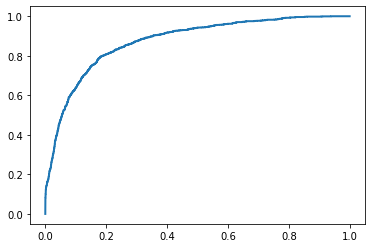

In [10]:
# None
logreg(weights[0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC: 0.8747704583571312


(LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([ 0.93775644, -1.73782584, -3.03044208, ..., -2.44859204,
        -1.91462015, -1.45939875]),
 array([0.        , 0.        , 0.        , ..., 0.93588381, 0.93588381,
        1.        ]),
 array([0.00000000e+00, 6.57030223e-04, 5.84756899e-02, ...,
        9.99342970e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  7.10874377,   6.10874377,   4.32612135, ...,  -4.09413489,
         -4.10091118, -11.12372018]))

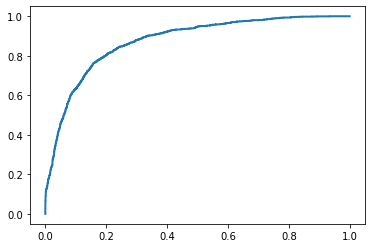

In [11]:
# balanced 
logreg(weights[1])

LogisticRegression(C=1000000000000.0, class_weight={0: 0.64, 1: 0.36},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
AUC: 0.8724425744413148


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(LogisticRegression(C=1000000000000.0, class_weight={0: 0.64, 1: 0.36},
                    dual=False, fit_intercept=True, intercept_scaling=1,
                    l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                    penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([-0.26105515, -3.21322263, -3.98630658, ..., -4.1241345 ,
        -2.84527659, -2.61868799]),
 array([0.        , 0.        , 0.        , ..., 0.94226001, 0.94226001,
        1.        ]),
 array([0.00000000e+00, 6.57030223e-04, 5.78186597e-02, ...,
        9.99342970e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  6.04171648,   5.04171648,   3.30729769, ...,  -5.40769485,
         -5.41745159, -12.50097609]))

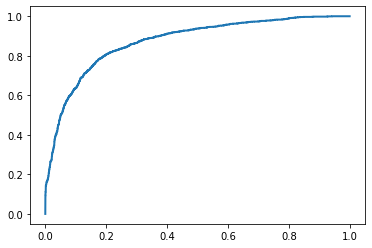

In [12]:
logreg(weights[2])

In [14]:
# initialize smote 
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts())#Preview synthetic sample class distribution
# 50 to 50 

1    8298
0    8298
dtype: int64


In [16]:
logreg = LogisticRegression(fit_intercept = True, max_iter=200, C = 1e6,solver ='lbfgs')
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log
y_hat_test = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC:', auc(fpr, tpr))

AUC: 0.8749999418145393


In [21]:
# grid search 
pipe = Pipeline([('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear','lbfgs']}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.4s finished


In [22]:
best_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 LogisticRegression(C=0.03359818286283781, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='warn',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [23]:
best_clf.best_params_

{'classifier': LogisticRegression(C=0.03359818286283781, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 0.03359818286283781,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [24]:
best_clf.best_score_

0.8188583704158355

In [26]:
y_pred = best_clf.predict(X_test)

In [27]:

accuracy_score(y_test,clf.predict(X_test))

0.8082853855005754

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
auc(fpr, tpr)

0.7738860626271062

In [35]:
clf.predict(X_test)[:5], y_test[:5]
clf.classes_

array([0, 1])

In [39]:


pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), index = ['True_0','True_1'], columns = ['Pred_0','Pred_1'])

,Pred_0,Pred_1
True_0,2509,314
True_1,519,1003


In [40]:
def confusion_table(real_label, pred_label):
    '''
    inputs:
    real_label: an array of class values that are true 
    pred_label: an array of predicted class values
    returns:
    a confusion matrix table
    '''
    matrix = confusion_matrix(real_label, pred_label)
    df = pd.DataFrame(matrix, index = ['True_0','True_1'], columns = ['Pred_0','Pred_1'])
    return df
    

In [41]:
confusion_table(y_test, clf.predict(X_test))

,Pred_0,Pred_1
True_0,2509,314
True_1,519,1003


In [42]:
confusion_table(y_train, clf.predict(X_train))

,Pred_0,Pred_1
True_0,7498,800
True_1,1548,3188


In [48]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2823
           1       0.76      0.66      0.71      1522

    accuracy                           0.81      4345
   macro avg       0.80      0.77      0.78      4345
weighted avg       0.81      0.81      0.80      4345



In [51]:
balanced_accuracy_score(y_test, clf.predict(X_test))

0.7738860626271062

Text(0.5, 0, 'recall')

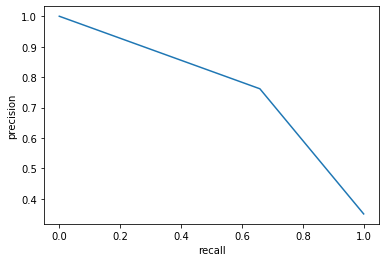

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test,clf.predict(X_test))
plt.plot(recall, precision, label='precision recall curve')
plt.ylabel('precision')
plt.xlabel('recall')

In [79]:
clf.classes_

array([0, 1])

In [85]:
np.int64(clf.predict_proba(X_test)[:,1]>0.4)

array([1, 0, 0, ..., 0, 0, 0])

In [86]:
clf.predict_proba(X_test)[:,1]>0.4

array([ True, False, False, ..., False, False, False])

In [97]:
def plot_auc_curve(true_y, pred_y, cutoff):
    '''
    inputs:
    true_y: array of true_y values
    pred_y: array of pred_y values 
    cutoffs: cutoff point for classificaiton
    returns:
    auc_curve and auc area 
    '''
    fpr, tpr, thresholds = roc_curve(true_y, pred_y)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve {cutoff}')
    plt.legend()
    return area

0.3: 0.7881530212451409
0.31: 0.7899042872443971
0.32: 0.7918069518126633
0.33: 0.7963663645212058
0.34: 0.7996345254836027
0.35000000000000003: 0.8031312389360347
0.36000000000000004: 0.8050339035043008
0.37000000000000005: 0.8044855637216909
0.38000000000000006: 0.8019889419695452
0.39000000000000007: 0.8001750684144647
0.4000000000000001: 0.8004836840985653


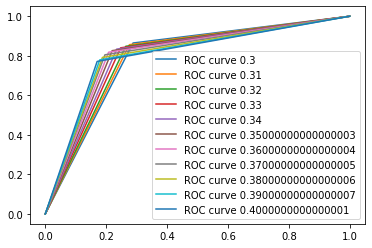

In [106]:
thresholds = np.arange(0.3,0.4,0.01)
for t in thresholds:
    pred_y = np.int64(clf.predict_proba(X_test)[:,1]>t)
    print(f'{t}:',plot_auc_curve(y_test, pred_y, t))
# use cut of 0.36

In [107]:
t = 0.36
y_pred = np.int64(clf.predict_proba(X_test)[:,1]>t)

Text(0.5, 0, 'recall')

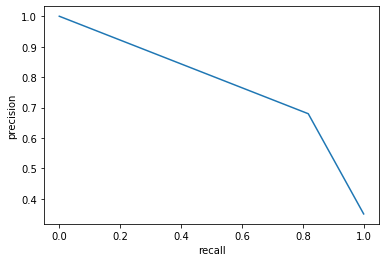

In [109]:
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
plt.plot(recall, precision, label='precision recall curve')
plt.ylabel('precision')
plt.xlabel('recall')

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      2823
           1       0.68      0.82      0.74      1522

    accuracy                           0.80      4345
   macro avg       0.78      0.81      0.79      4345
weighted avg       0.82      0.80      0.80      4345



In [112]:
balanced_accuracy_score(y_test, y_pred)

0.8050339035043008

In [113]:
confusion_table(y_test, y_pred)

,Pred_0,Pred_1
True_0,2236,587
True_1,277,1245
